In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
from cmocean import cm # for oceanography-specific colormaps
from scipy.io import loadmat
import numpy as np
import re
from xml.etree import ElementTree as ET
from matplotlib.path import Path
import pandas as pd

In [ ]:
ds = xr.open_dataset('../../NHCS/hincast_1980-2015/croco_avg_Y1980M01.nc', 
                     chunks = {'time':1})
ds

## Load Functions

## Functions

In [4]:
## kml to struct
def kml2struct(kml_file):
    """
    Import a .kml file as a list of dictionary structures with fields:
    Geometry, Name, Description, Lon, Lat, and BoundingBox.
    """
    # Read the KML file
    try:
        with open(kml_file, 'r', encoding='utf-8') as file:
            txt = file.read()
    except Exception as e:
        raise FileNotFoundError(f"Unable to open file {kml_file}: {e}")

    # Regular expression to match Placemark tags
    expr = r"<Placemark.+?>.+?</Placemark>"
    object_strings = re.findall(expr, txt, re.DOTALL)
    
    kml_struct = []

    for obj_str in object_strings:
        # Extract Name
        name_match = re.search(r"<name.*?>(.*?)</name>", obj_str, re.DOTALL)
        name = name_match.group(1).strip() if name_match else "undefined"

        # Extract Description
        desc_match = re.search(r"<description.*?>(.*?)</description>", obj_str, re.DOTALL)
        desc = desc_match.group(1).strip() if desc_match else ""

        # Determine Geometry Type
        geometry = ""
        if "<Point" in obj_str:
            geometry = "Point"
        elif "<LineString" in obj_str:
            geometry = "Line"
        elif "<Polygon" in obj_str:
            geometry = "Polygon"

        # Extract Coordinates
        coord_match = re.search(r"<coordinates.*?>(.*?)</coordinates>", obj_str, re.DOTALL)
        if not coord_match:
            continue  # Skip if no coordinates are found
        coord_str = coord_match.group(1).strip()
        coord_list = np.array([list(map(float, coord.split(','))) for coord in coord_str.split()])

        # Separate Lon, Lat, and handle Polygons
        lon = coord_list[:, 0]
        lat = coord_list[:, 1]
        if geometry == "Polygon":
            # Close the polygon by appending NaN
            lon = np.append(lon, np.nan)
            lat = np.append(lat, np.nan)

        # Create BoundingBox
        bounding_box = [[lon.min(), lat.min()], [lon.max(), lat.max()]]

        # Append to kml_struct
        kml_struct.append({
            "Geometry": geometry,
            "Name": name,
            "Description": desc,
            "Lon": lon,
            "Lat": lat,
            "BoundingBox": bounding_box
        })

    return kml_struct

In [5]:
# Load the KML file to get the polygon boundary
arch_kml_zona1 = "../../NHCS/hindcast/CROCO_BioEBUS_1990-2010/indices/BK150km.kml"
R1 = kml2struct(arch_kml_zona1)

# Extract Lon and Lat from the first polygon
lonb1 = R1[0]["Lon"]
latb1 = R1[0]["Lat"]

## Lon and lat for the whole dataset
lat = np.linspace(-33.0, 10.03286, 542).reshape(542, 1)  # Reshape to match eta_rho
lon = np.linspace(-118.9083, -68.90833, 602).reshape(1, 602)  # Reshape to match xi_rho

lats, lons = np.meshgrid(lat.flatten(), lon.flatten(), indexing="ij")

LON=lons
LAT=lats
# Create a path from the polygon coordinates
polygon = Path(np.column_stack((lonb1, latb1)))

# Flatten the LON and LAT to create coordinate pairs
lonlat_points = np.column_stack((LON.ravel(), LAT.ravel()))

# Check which points are inside the polygon
mask = polygon.contains_points(lonlat_points).reshape(LON.shape)

# Convert the mask to NaN for the outshore region
inshore_mask = np.where(mask, 1, np.nan)

In [6]:
Puertos = {
    "Pisco":  [-13.69388889,  -76.22416667],
    "Callao":   [-12.0575,  -77.15305556],
    "Chimbote": [-9.076666667,  -78.61472222],
    "Paita":    [-5.078055556,  -81.10638889],
    }

In [7]:
##Normalize
def normalize(data):
    return (data - data.min()) / (data.max() - data.min())

## Load Indices

## Latitudinal Mean

## Latitudinal Mean

In [98]:
WMLD_lat = WMLD_ds_['WMLD'] * inshore_mask
# WMLD_lat
CUI_ds

# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,7))
# WMLD_lat.mean(dim='lon').sel(lat=slice(-20,0)).mean(dim='time').rolling(lat=13,center=True).mean().plot(ax=ax,y='lat')
# plt.grid()
# plt.ylim([-16, -5])

<xarray.DataArray 'CUI_cc' (time: 432, lat: 185)> Size: 320kB
array([[1.0513515 , 1.0935459 , 1.1349678 , ..., 3.044176  , 2.9407597 ,
        2.855959  ],
       [0.8243084 , 0.73539925, 0.6374855 , ..., 1.8800182 , 1.8974552 ,
        1.9528027 ],
       [0.22629738, 0.5072441 , 0.7329922 , ..., 2.8429527 , 2.7723064 ,
        2.8034554 ],
       ...,
       [0.97706604, 1.0218201 , 1.0204983 , ..., 1.2903767 , 1.3467522 ,
        1.3760109 ],
       [1.3990173 , 1.502945  , 1.608551  , ..., 0.064394  , 0.16672325,
        0.2874241 ],
       [2.415516  , 2.4410248 , 2.4481964 , ..., 1.7548542 , 1.7767258 ,
        1.8258553 ]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 3kB 1980-01-31 1980-02-29 ... 2015-12-31
  * lat      (lat) float64 1kB -19.99 -19.92 -19.84 ... -5.242 -5.159 -5.076

(-16.0, -5.0)

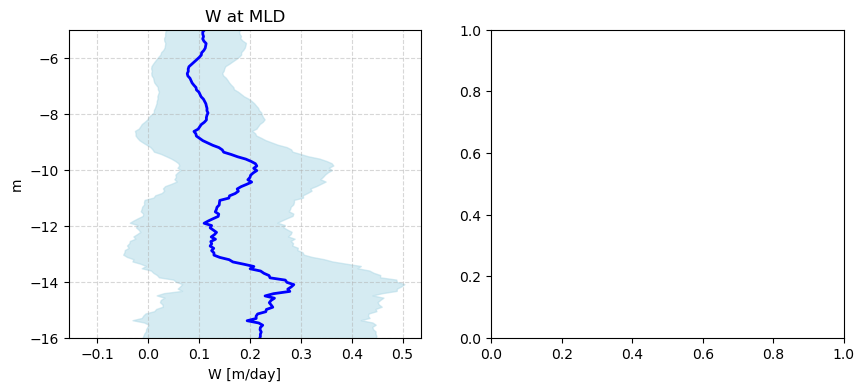

In [96]:
# wmld_lat = WMLD_lat.mean(dim='lon').sel(lat=slice(-20,0)).mean(dim='time').rolling(lat=13,center=True).mean() 
wmld_lat = WMLD_lat.mean(dim='lon').sel(lat=slice(-20,0)) * 86400

w_mean_ = wmld_lat.mean(dim='time').rolling(lat=13,center=True).mean()  # Mean across time for each depth
w_std_ = wmld_lat.std(dim='time').rolling(lat=13,center=True).mean()    # Standard deviation across time for each depth


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,4))

axes[0].plot(w_mean_, w_mean_['lat'], color='blue', label='Mean', linewidth=2)
axes[0].fill_betweenx(w_mean_['lat'], w_mean_ - w_std_, w_mean_ + w_std_, 
                  color='lightblue', alpha=0.5, label='±1 SD')
axes[0].set_title('W at MLD')
axes[0].grid(linestyle='--', alpha=0.5)
axes[0].set_xlabel('W [m/day]')
axes[0].set_ylabel('m')
axes[0].set_ylim([-16, -5])
# axes[0].axvline(0, color='black', linestyle='--', linewidth=1)